In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project-hotel-reviews/train.csv
/kaggle/input/project-hotel-reviews/test (2).csv


> # IMPORT LIBRARIES

In [2]:
!pip install contractions

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [35]:
import seaborn as sns
import spacy
import time
import re
import string
from nltk import pos_tag
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import fasttext
import contractions
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import contractions

ModuleNotFoundError: No module named 'contractions'

> #  DATASET AND PREPROCESSING

In [3]:
reviews=pd.read_csv("../input/project-hotel-reviews/train.csv")

In [4]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews["review_clean"] = reviews["Review"].apply(lambda x: clean_text(x))

In [5]:
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" #List of punctuation to remove

#ReviewParse: Takes the stubborn punctuation off the words for a single review
#Input: the review to parse
#Output: the parsed review
def reviewParse(review):
    splitReview = review.split() #Split the review into words
    parsedReview = "".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview]) #Takes the stubborn punctuation out
    return parsedReview #Returns the parsed review

reviews["review_clean"] = reviews["Review"].apply(reviewParse) #Parse all the reviews for their punctuation and add it into a new column
reviews.head() #Take a peek at the dataset

,ID,Review,Rating,review_clean
0,0,exceptional service nice all-around daughter s...,5,exceptional service nice allaround daughter st...
1,1,beautiful relaxing jw marriott desert ridge re...,5,beautiful relaxing jw marriott desert ridge re...
2,2,great location great location 5 mins subway ta...,5,great location great location 5 mins subway ta...
3,3,"pleased nice safe hotel, flower market hotel v...",3,pleased nice safe hotel flower market hotel va...
4,4,excellent hotel service great hotel excellent ...,4,excellent hotel service great hotel excellent ...


In [8]:
#as ID Column is not important so we are dropping it.
reviews.drop("ID",axis=1,inplace=True)
reviews.head()

,Review,Rating,review_clean
0,exceptional service nice all-around daughter s...,5,exceptional service nice allaround daughter st...
1,beautiful relaxing jw marriott desert ridge re...,5,beautiful relaxing jw marriott desert ridge re...
2,great location great location 5 mins subway ta...,5,great location great location 5 mins subway ta...
3,"pleased nice safe hotel, flower market hotel v...",3,pleased nice safe hotel flower market hotel va...
4,excellent hotel service great hotel excellent ...,4,excellent hotel service great hotel excellent ...


> # LABELLING DATASET

In [9]:
pos = [4, 5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1

In [10]:
reviews['Sentiment'] = reviews['Rating'].apply(sentiment)
reviews.head()

,Review,Rating,review_clean,Sentiment
0,exceptional service nice all-around daughter s...,5,exceptional service nice allaround daughter st...,2
1,beautiful relaxing jw marriott desert ridge re...,5,beautiful relaxing jw marriott desert ridge re...,2
2,great location great location 5 mins subway ta...,5,great location great location 5 mins subway ta...,2
3,"pleased nice safe hotel, flower market hotel v...",3,pleased nice safe hotel flower market hotel va...,1
4,excellent hotel service great hotel excellent ...,4,excellent hotel service great hotel excellent ...,2


> # SPLITTING DATA

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x = reviews["review_clean"]
y = reviews["Sentiment"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=8)

In [15]:
X_train,y_train

(912      majestic great booked majestic honeymoon pleas...
 4144     great location just come staying hotel nights ...
 10037    nice hotel nice clean hotel staff friendly hel...
 13237    great service fantastic vacation say thanks st...
 10169    regular amazing value stay hotel let great bed...
                                ...                        
 2181     great location design affordable madrid stop h...
 10601    wonderful place stay family stayed embassy sui...
 2033     loved stay arrived hotel new right away pleasa...
 9556     good bit rundown stayed room 1 entry hallway l...
 4547     oasis heart city second time stayed library ho...
 Name: review_clean, Length: 12191, dtype: object,
 912      2
 4144     2
 10037    2
 13237    2
 10169    2
         ..
 2181     2
 10601    2
 2033     2
 9556     1
 4547     2
 Name: Sentiment, Length: 12191, dtype: int64)

> # VECTORISATIONS

In [18]:
#BAG-OF-WORDS-COUNTVECTORIZER
from sklearn.feature_extraction.text import CountVectorizer


The Bag of Words model allows us to extract features from our textual data and in this example, we take out all the words from each of the observations and pool them together in a sort of “bag” to reduce redundancy by not counting duplicates. we did this by importing the CountVectorizer class from sklearn.

Each word forms its own column in a way, and since there are so many words, we could have a huge number of columns. However, I specified the maximum number of columns using the max_features parameter of the CountVectorizer class.




In [19]:
cv = CountVectorizer(max_features = 300)
X_train.cv = cv.fit_transform(X_train).toarray()
y_train.cv = reviews.iloc[:, 2].values

In [20]:
X_test.cv = cv.fit_transform(X_test).toarray()
y_test.cv = reviews.iloc[:, 2].values

In [22]:
X_train.cv,y_train.cv

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array(['exceptional service nice allaround daughter stayed wellpriced hotel 99 night king suite weekend nights really impressed exceptionally welcoming service time reservation departure hotel employee talked really friendly eager help questions amazed day agethe lshaped hotel pool tiny looked like fun kids hottub exercise room wellbreakfast abundant make waffles add scrambled eggs bacon sausage fruit available bagels muffins oatmeal yogurt just wanted morning sort long line waiting make waffles waiting scrambled eggs pickyour room really nice asked away freeway reading reviews earlier bit noisy hey city felt like deluxe room considering reasonable price nice bedding art walls really liked space needle bit windowthe shuttle runs hourly nt reserve certain place certain time wo

In [ ]:
############################################################################

In [23]:
#TF-IDF
!pip install tfidf


  Created wheel for tfidf: filename=tfidf-0.0.6-py3-none-any.whl size=2411 sha256=28db476ff5091c85e4d9681125a388725ac28a2770c0700658cc8d25b19f7350
  Stored in directory: /root/.cache/pip/wheels/8b/72/4a/8d8079ffe00a3cae49d05cb28fa94f318ae97276a888e28a68
  Created wheel for etl-utils: filename=etl_utils-0.1.11-py3-none-any.whl size=21643 sha256=5e9533ea11c6fb074dd17c227e12e1b890e8ee762f3f37d84350bc9c764f550a
  Stored in directory: /root/.cache/pip/wheels/f4/d1/fa/7f8f0b3bdcced0f1205bac981c449925992e5c785bfcd15dde
  Created wheel for progressbar: filename=progressbar-2.2-py3-none-any.whl size=6447 sha256=5927b1941e86364b70d5700c397a01d2157a29b7cf43794599d6bb174c54d5c8
  Stored in directory: /root/.cache/pip/wheels/ed/19/57/6fd2895583ffe9b5663099963c99f4a3e3d226c6d8c1c718c0
  Created wheel for pysingleton: filename=pysingleton-0.2.1-py3-none-any.whl size=2196 sha256=7b872a4c3547a39490f68871c0c7a43750cdca3001e9518216d21e6c20f984bd
  Stored in directory: /root/.cache/pip/wheels/3b/50/bd/ac4

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

We'll use TF-IDF Vectors as features.

We have to define the different parameters:

ngram_range: We want to consider both unigrams and bigrams. 
max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold 
min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [24]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [26]:

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

In [27]:
X_train.tfidf = tfidf.fit_transform(X_train).toarray()
y_train.tfidf = y_train
print(X_train.tfidf.shape)

(12191, 300)


In [28]:
X_test.tfidf = tfidf.transform(X_test).toarray()
y_test.tfidf = y_test
print(X_test.tfidf.shape)

(2152, 300)


In [ ]:
##############################################################################

In [29]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

In [ ]:
##################### LINEAR SVC #####################

In [30]:
#Linear SVC
clf=LinearSVC(C=10,class_weight='balanced')

In [31]:
#using bow
clf.fit(X_train.cv,y_train)
y_pred=clf.predict(X_test.cv)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.21      0.26      0.23       337
           1       0.18      0.30      0.23       257
           2       0.77      0.65      0.70      1558

    accuracy                           0.55      2152
   macro avg       0.39      0.40      0.39      2152
weighted avg       0.61      0.55      0.57      2152



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
#using tfidf
clf.fit(X_train.tfidf,y_train)
y_pred=clf.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.75      0.69       337
           1       0.37      0.31      0.34       257
           2       0.91      0.90      0.90      1558

    accuracy                           0.80      2152
   macro avg       0.64      0.65      0.64      2152
weighted avg       0.80      0.80      0.80      2152



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [40]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='clf'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

In [48]:
import matplotlib.pyplot as plt

In [42]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)


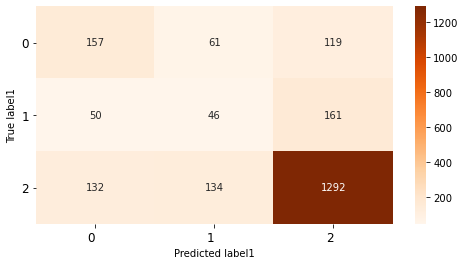

In [49]:

print_confusion_matrix(conf_mat, uniq_labels)

In [50]:
accuracy_score(y_test,y_pred)

0.6947026022304833

In [51]:
d = {
     'Model': 'Linear SVC',
     'Training Set Accuracy': accuracy_score(y_test, y_pred),

}

Linear_svc = pd.DataFrame(d, index=[0])

In [52]:
Linear_svc

,Model,Training Set Accuracy
0,Linear SVC,0.694703


In [54]:
import pickle

In [55]:
with open('clf.pickle', 'wb') as output:
    pickle.dump(clf, output)
    
with open('clf_mod.pickle', 'wb') as output:
    pickle.dump(Linear_svc, output)

In [ ]:
##############################  DECISION TREE ###########################

In [43]:
#DECISION TREE


classifier_DT = DecisionTreeClassifier(random_state = 0)


In [44]:
#using bow
classifier_DT.fit(X_train.cv,y_train)
y_pred=classifier_DT.predict(X_test.cv)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.21      0.42      0.28       337
           1       0.14      0.17      0.15       257
           2       0.78      0.58      0.66      1558

    accuracy                           0.50      2152
   macro avg       0.37      0.39      0.36      2152
weighted avg       0.61      0.50      0.54      2152



In [45]:
#using TFIDF
classifier_DT.fit(X_train.tfidf,y_train)
y_pred=classifier_DT.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.46      0.47      0.46       337
           1       0.19      0.18      0.18       257
           2       0.82      0.83      0.83      1558

    accuracy                           0.69      2152
   macro avg       0.49      0.49      0.49      2152
weighted avg       0.69      0.69      0.69      2152



In [46]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='classifier_DT'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

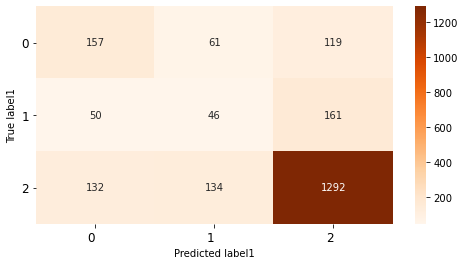

In [56]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)

print_confusion_matrix(conf_mat, uniq_labels)

In [68]:
accuracy_score(y_test,y_pred)


0.7518587360594795

In [66]:
d = {
     'Model': 'Decision Tree',
     'Training Set Accuracy': accuracy_score(y_test, y_pred),

}

clf_DT = pd.DataFrame(d, index=[0])

In [67]:
clf_DT

,Model,Training Set Accuracy
0,Decision Tree,0.751859


In [69]:
with open('clf_DT.pickle', 'wb') as output:
    pickle.dump(classifier_DT, output)
    
with open('clfDT_mod.pickle', 'wb') as output:
    pickle.dump(clf_DT, output)

In [ ]:
############################## MULTINOMIAL NAIVE BAYES ####################

In [60]:
#(Naive Bayes)
from sklearn.naive_bayes import MultinomialNB

model_mnbc = MultinomialNB()

In [61]:
#Using bow
model_mnbc.fit(X_train.cv,y_train)
y_pred=model_mnbc.predict(X_test.cv)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.16      0.23      0.19       337
           1       0.20      0.28      0.23       257
           2       0.76      0.64      0.69      1558

    accuracy                           0.53      2152
   macro avg       0.37      0.38      0.37      2152
weighted avg       0.60      0.53      0.56      2152



In [71]:
#Using Tf-Idf
model_mnbc.fit(X_train.tfidf,y_train)
y_pred=model_mnbc.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.20      0.31       337
           1       0.00      0.00      0.00       257
           2       0.75      1.00      0.86      1558

    accuracy                           0.75      2152
   macro avg       0.50      0.40      0.39      2152
weighted avg       0.66      0.75      0.67      2152



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='model_mnbc'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

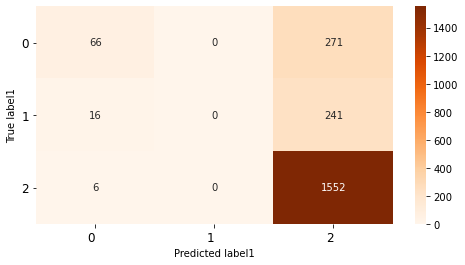

In [73]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)

print_confusion_matrix(conf_mat, uniq_labels)

In [74]:
accuracy_score(y_test,y_pred)


0.7518587360594795

In [75]:
d = {
     'Model': 'Multinomial Naive Bayes',
     'Training Set Accuracy': accuracy_score(y_test, y_pred),

}

clf_mnbc = pd.DataFrame(d, index=[0])

In [76]:
clf_mnbc

,Model,Training Set Accuracy
0,Multinomial Naive Bayes,0.751859


In [77]:
with open('clf_mnbc.pickle', 'wb') as output:
    pickle.dump(model_mnbc, output)
    
with open('clf_mod.pickle', 'wb') as output:
    pickle.dump(clf_mnbc, output)

In [ ]:
############################ RANDOM FOREST #############################

In [78]:
#RANDOM FOREST
classifier_RF = RandomForestClassifier(n_estimators = 300, random_state = 0)

In [79]:
#Using Tf-Idf
classifier_RF.fit(X_train.tfidf,y_train)
y_pred=classifier_RF.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.41      0.54       337
           1       0.40      0.01      0.02       257
           2       0.79      0.99      0.88      1558

    accuracy                           0.78      2152
   macro avg       0.65      0.47      0.48      2152
weighted avg       0.74      0.78      0.72      2152



In [80]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='classifier_RF'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

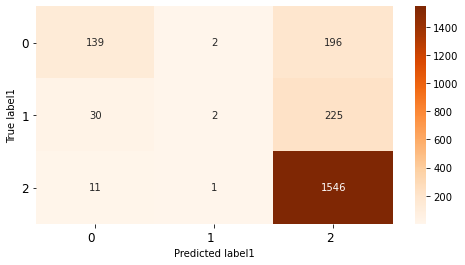

In [81]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)

print_confusion_matrix(conf_mat, uniq_labels)

In [82]:
accuracy_score(y_test,y_pred)


0.7839219330855018

In [83]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(y_test, y_pred),

}

clf_RF = pd.DataFrame(d, index=[0])

In [84]:
clf_RF

,Model,Training Set Accuracy
0,Random Forest,0.783922


In [85]:
with open('clf_RF.pickle', 'wb') as output:
    pickle.dump(classifier_RF, output)
    
with open('clf_RF_MOD.pickle', 'wb') as output:
    pickle.dump(clf_RF, output)

In [ ]:
###############################LOGISTIC REGRESSION###############################

In [86]:
clf_LG = LogisticRegression(solver='lbfgs', max_iter=1000)

In [87]:
#Using Tf-Idf
clf_LG.fit(X_train.tfidf,y_train)
y_pred=clf.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.75      0.69       337
           1       0.37      0.31      0.34       257
           2       0.91      0.90      0.90      1558

    accuracy                           0.80      2152
   macro avg       0.64      0.65      0.64      2152
weighted avg       0.80      0.80      0.80      2152



In [88]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='clf_LG'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

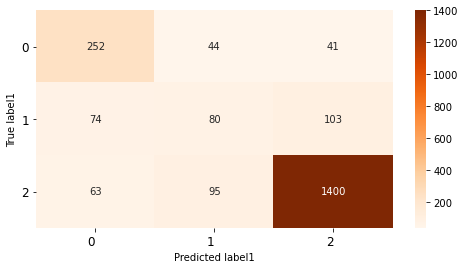

In [89]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)

print_confusion_matrix(conf_mat, uniq_labels)

In [90]:
d = {
     'Model': 'Logg_Reg',
     'Training Set Accuracy': accuracy_score(y_test.tfidf, y_pred),

}

LOG_REG = pd.DataFrame(d, index=[1])

In [91]:
LOG_REG

,Model,Training Set Accuracy
1,Logg_Reg,0.804833


In [92]:
with open('LOG_R.pickle', 'wb') as output:
    pickle.dump(clf_LG, output)
    
with open('clf_mod.pickle', 'wb') as output:
    pickle.dump(LOG_REG, output)

In [ ]:
#############################BOOSTING #################################

In [93]:
from xgboost import XGBClassifier
model_XGB = XGBClassifier()

In [94]:

model_XGB.fit(X_train.tfidf, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
y_pred=model_XGB.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.64      0.69       337
           1       0.40      0.11      0.18       257
           2       0.85      0.97      0.90      1558

    accuracy                           0.82      2152
   macro avg       0.66      0.57      0.59      2152
weighted avg       0.77      0.82      0.78      2152



In [96]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='model_XGB'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

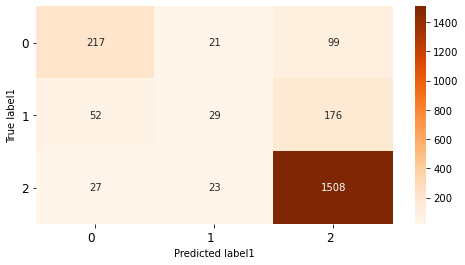

In [97]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)

print_confusion_matrix(conf_mat, uniq_labels)

In [102]:
d = {
     'Model': 'XGBOOST',
     'Training Set Accuracy': accuracy_score(y_test.tfidf, y_pred),

}

XG_BO = pd.DataFrame(d, index=[1])

In [103]:
XG_BO

,Model,Training Set Accuracy
1,XGBOOST,0.745818


In [104]:
with open('XG_B.pickle', 'wb') as output:
    pickle.dump(model_XGB, output)
    
with open('XG_mod.pickle', 'wb') as output:
    pickle.dump(XG_BO, output)

In [105]:
#CATBOOST
from catboost import CatBoostClassifier

catb = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)


In [106]:
#Using Tf-Idf
catb.fit(X_train.tfidf,y_train)
y_pred=catb.predict(X_test.tfidf)
print(classification_report(y_test,y_pred))

0:	learn: 1.0114585	total: 253ms	remaining: 1.01s
1:	learn: 0.9446086	total: 518ms	remaining: 777ms
2:	learn: 0.8907441	total: 774ms	remaining: 516ms
3:	learn: 0.8485794	total: 1.02s	remaining: 255ms
4:	learn: 0.8134393	total: 1.26s	remaining: 0us
              precision    recall  f1-score   support

           0       0.61      0.17      0.27       337
           1       0.00      0.00      0.00       257
           2       0.75      0.99      0.86      1558

    accuracy                           0.75      2152
   macro avg       0.45      0.39      0.37      2152
weighted avg       0.64      0.75      0.66      2152



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='catb'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm1 = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm1, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label1')
    plt.xlabel('Predicted label1')
    
    plt.show()

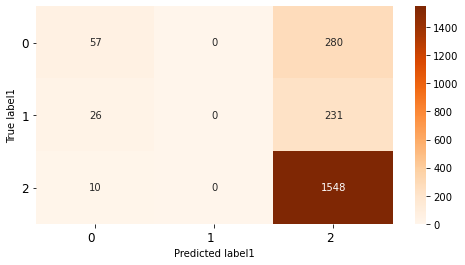

In [101]:
conf_mat = confusion_matrix(y_test, y_pred)
uniq_labels = unique_labels(y_test, y_pred)

print_confusion_matrix(conf_mat, uniq_labels)

In [108]:
d = {
     'Model': 'CATBOOST',
     'Training Set Accuracy': accuracy_score(y_test.tfidf, y_pred),

}

CAT_BO = pd.DataFrame(d, index=[1])

In [109]:
CAT_BO

,Model,Training Set Accuracy
1,CATBOOST,0.745818


In [114]:
with open('CAT_B.pickle', 'wb') as output:
    pickle.dump(catb, output)
    
with open('CAT_mod.pickle', 'wb') as output:
    pickle.dump(CAT_BO, output)

In [ ]:
#######################################################

In [ ]:
#####################################################################################

> # WORD-EMBEDDINGS-WORD2VEC

In [124]:
#word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

Instead of using a pre-trained model, I am going to fit my own Word2Vec on the training data corpus with gensim. 
Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams. In this particular case, I’ll try to capture unigrams , bigrams , and trigrams .

In [120]:
corpus=X_train
y=reviews["Sentiment"]

In [126]:
import gensim

In [127]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detecto = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detecto)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [128]:
## fit w2v
nlp= gensim.models.word2vec.Word2Vec(lst_corpus, size=300,window=85  
            , min_count=1, sg=1)

In [131]:
#Created Vocabulary
vocabulary = nlp.wv.vocab
#print(vocabulary)

In [132]:
nlp.wv.most_similar(positive="dinner")

[('lunch', 0.737928032875061),
 ('buffet', 0.6451829075813293),
 ('ate', 0.6294734477996826),
 ('eat', 0.6201741695404053),
 ('evening', 0.599029004573822),
 ('makaido', 0.5909895896911621),
 ('garbed', 0.589614987373352),
 ('stylewe', 0.5884283185005188),
 ('restaurant', 0.5865685343742371),
 ('reservations', 0.5824744701385498)]

In [135]:
from keras.preprocessing.text import Tokenizer
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K


First, converted the corpus into a padded sequence of word id to obtain a feature matrix.

Then, created an embedding matrix so that the word vector with id N is located in the Nth row.

Finally, a neural network with an embedded layer is built, and each word in the sequence is weighted with a corresponding vector.

Still starting from feature engineering, use tensorflow/keras to convert the same preprocessed corpus (n-grams list) of Word2Vec into a list of text sequences:

In [136]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [137]:
tokenizer.texts_to_sequences(["i am nice girl"])

[[7084, 1373, 12, 1431]]

In [138]:
#ON TEST DATA
corpus = X_test
y=reviews["Rating"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

size of feature matrix in figure is 

every text in the corpus is an id sequence of length 15. For example, if there are 10 tokens in a text, then the sequence consists of 10 ids and 5 0s. This 0 is the filling element (while the words that are not in the vocabulary have an id of 1). 

we need to create the matrix of embedding that will be used as a weight matrix in the neural network classifier.

In [139]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [140]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      17892000    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
_______________________________________________________________________________________

An embedding layer, as described above, takes text sequences as input and word vectors as weights.

A simple Attention layer, it does not affect the prediction, but it can capture the weight of each sample, so that it can be used as a good interpreter .

Two-layer bidirectional LSTM, used to model the two directions of words in the sequence.

The last two fully connected layers can predict the probability of each hotel review category.

Now let's train the model, but before testing on the actual test set, we have to draw a small validation set on the training set to verify the model performance.



In [141]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train

In [142]:

training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)


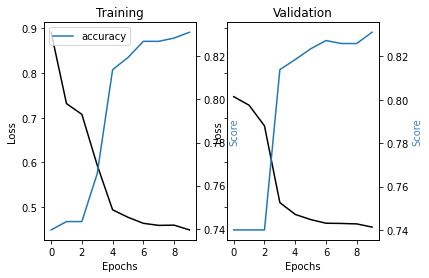

In [143]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

in some epochs the accuracy reach 83%

In [145]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

an Attention layer is placed in the neural network to extract the weight of each word, we can understand how much these weights contribute to the classification of a sample.

In [ ]:
predicted

In [146]:
## select observation
i = 2
txt_instance = corpus.iloc[i]

In [147]:
txt_instance

'miramar excellent location miramar great location stayed 6 nites september 2005 definitely stay booked standard room expedia good price able use swimming pool big pool no extra charge bathroom grout dirty didnt liquid soap bathing day key inroom safe didnt work manager fixed 1 public phone lobby staff not knowledgable free airport express shuttle bus stops right outside recommend miramar cuz excellent location spacious room nice toiletries '

In [148]:
## check true value and predicted value
print("True:", y_train[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))


True: 2 --> Pred: 0 | Prob: 0.61


In [ ]:
#predicted 0 cuz of words dirty,safe didn't work.

In [149]:
with open('word2vec.pickle', 'wb') as output:
    pickle.dump(predicted_prob, output)
    

In [ ]:
######################################################################

> # KERAS

In [151]:
import tensorflow as tf #Import tensorflow in order to use Keras
from tensorflow.keras.preprocessing.text import Tokenizer #Add the keras tokenizer for  tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences #Add padding to help the Keras Sequencing
import tensorflow.keras.layers as L #Import the layers as L for quicker typing
from tensorflow.keras.optimizers import Adam #Pull the adam optimizer for usage

from tensorflow.keras.losses import SparseCategoricalCrossentropy #Loss function being used

In [156]:
reviews_df=reviews

In [157]:
# LABEL ENCODING

#EncodeLabel: encode the labels into 0, 1, and 2, back to the issue of explaining positive and extremely positive to a machine
#Input: the star rating
#Output: 0, 1, or 2 indicating rating positivity/negativity

def encodeLabel(label):
    if label == 5 or label == 4: #If the rating is generally positive
        return 2 #Give the rating a 2 for positive
    if label == 3: #If the rating is generally neutral
        return 1 #Give the rating a 1 for neutral
    return 0 #Give the rating a 0 for negative

labels = ["Negative", "Neutral", "Positive"] #Give our labels a name
reviews_df["EncodedRating"] = reviews_df["Rating"].apply(encodeLabel) #Encode the ratings to positivity labels

In [158]:
review = reviews_df["review_clean"].copy() #Use a copy of the clean reviews

#Print an example sentence to make sure everything is working
print("Example Sentence: ") 
print(review[3])

token = Tokenizer() #Initialize the tokenizer
token.fit_on_texts(review) #Fit the tokenizer to the reviews
texts = token.texts_to_sequences(review) #Convert the reviews into sequences for keras to use

#Print an example sequence to make sure everything is working
print("Into a Sequence: ")
print(texts[3])

texts = pad_sequences(texts, padding='post') #Pad the sequences to make them similar lengths

#Print an example padded sequence to make sure everything is working
print("After Padding: ")
print(texts[3])

Example Sentence: 
pleased nice safe hotel flower market hotel vast array restaurants main gay district just hotel walking distance farthest walked slow walk anne frank house 3040 minutes corner new discover rooms small comfotable extremely clean staff helpful breakfast main dining room pricey euro 15 numerous cafes breakfast corner rebrandt square 
Into a Sequence: 
[591, 11, 229, 1, 2367, 398, 1, 3195, 3810, 42, 134, 3025, 693, 10, 1, 97, 212, 7229, 332, 625, 34, 2520, 2621, 395, 5142, 73, 330, 75, 2995, 12, 31, 15092, 157, 21, 7, 39, 22, 134, 477, 2, 705, 732, 276, 1145, 1086, 22, 330, 25474, 244]
After Padding: 
[591  11 229 ...   0   0   0]


In [159]:
# Model Training


textTrain, textTest, ratingTrain, ratingTest = train_test_split(texts, reviews_df["EncodedRating"], test_size = 0.30, random_state = 42)

In [160]:
size = len(token.word_index) + 1 #Set the number of words for the size
ratings = reviews_df["EncodedRating"].copy() #Get the encoded ratings from the dataframe

tf.keras.backend.clear_session() #Clear any previous model building

epoch = 2 #Number of runs through the data
batchSize = 32 #The number of items in each batch
outputDimensions = 16 #The size of the output
units = 256 #Dimensions of the output space

model = tf.keras.Sequential([ #Start the sequential model, doing one layer after another in a sequence
    L.Embedding(size, outputDimensions, input_length = texts.shape[1]), #Embed the model with the number of words and size
    L.Bidirectional(L.LSTM(units, return_sequences = True)), #Make it so the model looks both forward and backward at the data
    L.GlobalMaxPool1D(), #Take the max values over time
    L.Dropout(0.3), #Make the dropout 0.3, making about a third 0 to prevent overfitting
    L.Dense(64, activation="relu"), #Create a large dense layer
    L.Dropout(0.3), #Make the dropout 0.3, making about a third 0 to prevent overfitting
    L.Dense(3) #Create a small dense layer
])


model.compile(loss = SparseCategoricalCrossentropy(from_logits = True), #Compile the model with a SparseCategorical loss function
              optimizer = 'adam', metrics = ['accuracy'] #Add an adam optimizer and collect the accuracy along the way
             )

history = model.fit(textTrain, ratingTrain, epochs = epoch, validation_split = 0.2, batch_size = batchSize) #Fit the model to the data

Epoch 1/2
251/251 [==============================] - 73s 291ms/step - loss: 0.6322 - accuracy: 0.7758 - val_loss: 0.4471 - val_accuracy: 0.8376
Epoch 2/2
251/251 [==============================] - 73s 290ms/step - loss: 0.3935 - accuracy: 0.8485 - val_loss: 0.4209 - val_accuracy: 0.8426


In [161]:
# Make Predictions

predict = model.predict_classes(textTest) 
loss, accuracy = model.evaluate(textTest, ratingTest) 

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

135/135 [==============================] - 13s 99ms/step - loss: 0.4481 - accuracy: 0.8450
Test Loss:  0.44810089468955994
Test Accuracy:  0.8449918627738953


In [162]:
with open('predict.pickle', 'wb') as output:
    pickle.dump(predict, output)
    